# Author: Sumit Sarin

# Overview
* I tried 4 different neural networks and deep learning based approaches for solving this imbalanced multiclass classification problem.
* The best results were obtained by two methods as mentioned below in index.
* I tried to tackle class imbalance problem using class weights, SMOTE (oversampling) and Near miss (undersampling). SMOTE gave the best results.

##### Mount Google Drive

In [1]:
from google.colab import drive 
drive.mount('/mntDrive') 

ModuleNotFoundError: No module named 'google.colab'

# Index:
1. [Artificial Neural Network on feature vectors generated from opensmile](#method1) [Best Result][Used in final model]
2. [Generate spectrograms and apply CNN for classification](#method2)
3. [Apply LSTM on sequential spectogram](#method3)
4. [Infuse LSTM extracted feature vector with the opensmile features](#method4) [Best Result]
5. [Result](#result)
6. [Future Discussions](#future_discussion)
7. [Miscellaneous](#misc)

# Method 1 (Used in final result): Artificial Neural Network on feature vectors generated from opensmile <a id='another_cell'></a>

##### What I am doing:<br>
* I am first extracting opensmile features using the emo_large configuration.<br>
* Then I am building a neural network with 2 hidden layers (relu activation and 4096 neurons) and one output layer(softmax activation and 17 neurons). <br> 
* Softmax will give us log probabilities, and since this is NOT multilabel classification problem, we will choose the class with highest softmax value as the predicted class. <br>
* I am using dropout and L2 regularization to prevent overfitting. L2 regularization is chosen because it prevents the weights from becoming sparse, i.e., it encourages more dependence on large no of inputs.
* Hidden layers have relu activations because of the advantages relu offers, like it does not saturate the gradients.
* I have applied featurewise zero centering and normalization. The reason to normalize is so that we dont get huge gradient updates. Doing zero centering prevents the loss from decreasing in a zig zag manner which happens if all updates are positive or negative together.
* To tackle class imbalance i tried using class weights, SMOTE, random downsampling, random upsampling, and near miss algorithm. SMOTE gave the best results.
* I used a learning rate scheduler to decrease the learning rate appropriately.
* I tried both SGD and Adam. Adam reached lower loss more quickly.
* At the end, I calculate the precision, recall and F1 scores. Due to class imbalance it doesn't make sense to evaluate accuracy. Hence macro avg F1 scores is used as a metric for evaluating the best model.


##### Import modules

In [2]:
import numpy as np
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.utils import class_weight
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, LearningRateScheduler
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import NearMiss
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model

SyntaxError: invalid syntax (_metadata_requests.py, line 1512)

##### Hyperparameters, etc.

In [8]:
EPOCHS = 50
LR = 0.0001
BATCH_SIZE = 16
DROPOUT_RATE = 0.5
REG_STRENGTH = 0.01

EMOTIONS = ["disgust", "happy", "sad", "fear", "neutral"]

##### Run opensmile on every wav file and store it's output file (arff format).

In [11]:
import os
from glob import glob

train_path = "./train"
val_path = "./val"

os.makedirs("./train_csv")
os.makedirs("./val_csv")

for emotion in EMOTIONS:
    os.makedirs(os.path.join(train_path+"_csv", emotion))
    os.makedirs(os.path.join(val_path+"_csv", emotion))

for path in [train_path, val_path]:
    wav_files = glob(path+"/*/*.wav")

    for wav_file in wav_files:
        osmile_cmd = "/Users/sumitsarin/Downloads/opensmile-2.3.0/SMILExtract -C /Users/sumitsarin/Downloads/opensmile-2.3.0/config/emo_large.conf"
        osmile_cmd += " -I "+wav_file
        op_path = ((path+"_csv/")+wav_file.split(sep='/')[-2]+'/'+wav_file.split(sep='/')[-1])[:-3] +'arff'
        osmile_cmd += " -O "+op_path
        os.system(osmile_cmd) # Exectute opensmile command

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './train_csv'

##### Generate train and val splits from the feature vector files generated by opensmile.

In [3]:
X_train = []
y_train = []

path = train_path+'_csv'

arff_files = glob(path+"/*/*.arff")

for file_name in arff_files:
    f = open(file_name)
    lines = f.readlines()
    params = lines[6560].split(',')[1:-1]
    params = [float(i) for i in params]
    params = np.array(params)
    f.close()
    X_val.append(params)
    
    label = file_name.split(sep='/')[-2]
    label_id = EMOTIONS.index(label)  
    y_val.append(label_id)
    
X_train = np.array(X_val)
y_train = np.array(y_val)

NameError: name 'train_path' is not defined

In [0]:
X_val = []
y_val = []

path = val_path+'_csv'

arff_files = glob(path+"/*/*.arff")

for file_name in arff_files:
    f = open(file_name)
    lines = f.readlines()
    params = lines[6560].split(',')[1:-1]
    params = [float(i) for i in params]
    params = np.array(params)
    f.close()
    X_val.append(params)
    
    label = file_name.split(sep='/')[-2]
    label_id = EMOTIONS.index(label)  
    y_val.append(label_id)
    
X_val = np.array(X_val)
y_val = np.array(y_val)

##### Save sets for repeated use. The reason I am not using data in batches is because on google drive, the disk speeds are way too slow. I have mentioned the code I tried for generating batched audio data in miscellaneous section.

In [0]:
DIR = "/mntDrive/My Drive/meld/"

X_train.save(DIR+"X_train", X_train)
y_train.save(DIR+"y_train", y_train)
X_val.save(DIR+"X_val", X_val)
y_val.save(DIR+"y_val", y_val)

##### Load train and val split.

In [0]:
DIR = "/mntDrive/My Drive/meld/"

X_train = np.load(DIR+"X_train.npy")
y_train = np.load(DIR+"y_train.npy")
X_val = np.load(DIR+"X_val.npy")
y_val = np.load(DIR+"y_val.npy")

##### Zero center and normalize the data feature wise.
1. The reason to normalize is so that we dont get huge gradient updates. 
2. Doing zero centering prevents the loss to go down in a zig zag manner which happens if all updates are positive or negative together.

In [0]:
mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)

mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)

X_train -= mean
X_val -= mean

X_train = np.divide(X_train, std, out=np.zeros_like(X_train), where=std!=0)
X_val = np.divide(X_val, std, out=np.zeros_like(X_val), where=std!=0)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(7354, 6553) (7354,) (830, 6553) (830,)


##### Visualizing class frequencies

fear occurs least no of times: 215
neutral occurs max no of times: 4591


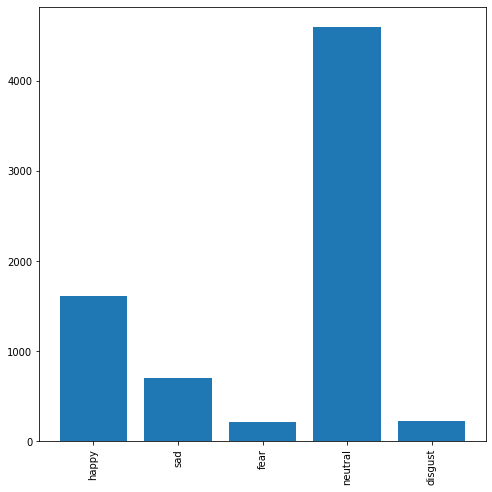

In [0]:
plt.figure(figsize=(8, 8))

class_count = {}

for y in y_train:
    if EMOTIONS[y] in class_count:
        class_count[EMOTIONS[y]] += 1
    else:
        class_count[EMOTIONS[y]] = 0
            
min_label = min(class_count, key=class_count.get)
max_label = max(class_count, key=class_count.get)
print(min_label+" occurs least no of times: "+str(class_count[min_label]))
print(max_label+" occurs max no of times: "+str(class_count[max_label]))
            
plt.bar(range(len(class_count)), list(class_count.values()), align='center')
plt.xticks(range(len(class_count)), list(class_count.keys()), rotation=90)

plt.show()

##### I tried handling class imbalance using the three methods mentioned below. SMOTE gives slightly better results so I used it in my final model.

##### 1. Through class weights:

In [0]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

##### 2. Through upsampling of minority classes using SMOTE.

In [0]:
sm = SMOTE(random_state = 2) 
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

print(X_train_sm.shape, y_train_sm.shape)

(22960, 6553) (22960,)


##### 3. Through downsampling of majority classes

In [0]:
nr = NearMiss()
X_train_nm, y_train_nm = nr.fit_sample(X_train, y_train)

print(X_train_nm.shape, y_train_nm.shape)

(1080, 6553) (1080,)


##### Create a keras model with a specified dropout and regularization strength. I found dropout of 0.5 and L2 reg strength of 0.01 well suited.

In [0]:
def create_model(dropout_rate, regularization_strength):
    """Returns tensorflow Sequential keras model"""
    model = Sequential()
    model.add(InputLayer((6553)))
    model.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(regularization_strength)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(regularization_strength)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(5, activation='softmax'))

    return model

In [0]:
clear_session()
model = create_model(DROPOUT_RATE, REG_STRENGTH)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              26845184  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 20485     
Total params: 43,646,981
Trainable params: 43,646,981
Non-trainable params: 0
_________________________________________________________________


##### Define a custom callback so we can track the macro avg f1 scores of the model on validation set, and save the model which gives best F1 score.

In [0]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.max_f1 = 0.0
 
    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.argmax(self.model.predict(X_val), axis=1)
        y_true = y_val
        _val_f1 = f1_score(y_true, y_pred, average='macro')
        self.val_f1s.append(_val_f1)
        print (" — val_f1: %f" %(_val_f1))

        if _val_f1 > self.max_f1:
            self.model.save_weights('model.h5')
            self.max_f1 = _val_f1

        return

##### Define custom learning rate scheduler.

In [0]:
def lr_scheduler(epoch):
    if epoch<15:
        return 0.0001
    return 0.00001

##### Run the model and tune the hyperparameters.

Train on 22960 samples, validate on 830 samples
Epoch 1/50
22960/22960 [==============================] - 55s 2ms/sample - loss: 47.8917 - acc: 0.5001 - val_loss: 20.1959 - val_acc: 0.3614
Epoch 2/50
22960/22960 [==============================] - 55s 2ms/sample - loss: 9.9944 - acc: 0.6106 - val_loss: 5.4911 - val_acc: 0.2590
Epoch 3/50
22960/22960 [==============================] - 55s 2ms/sample - loss: 3.1258 - acc: 0.6276 - val_loss: 2.6551 - val_acc: 0.4241
Epoch 4/50
22960/22960 [==============================] - 55s 2ms/sample - loss: 1.9991 - acc: 0.6318 - val_loss: 2.3629 - val_acc: 0.3952
Epoch 5/50
22960/22960 [==============================] - 55s 2ms/sample - loss: 1.7451 - acc: 0.6474 - val_loss: 2.5099 - val_acc: 0.2494
Epoch 6/50
22960/22960 [==============================] - 55s 2ms/sample - loss: 1.6427 - acc: 0.6596 - val_loss: 2.4211 - val_acc: 0.2795
Epoch 7/50
22960/22960 [==============================] - 55s 2ms/sample - loss: 1.6089 - acc: 0.6747 - val_loss: 2.

Text(0.5, 1.0, 'Validation F1 Scores')

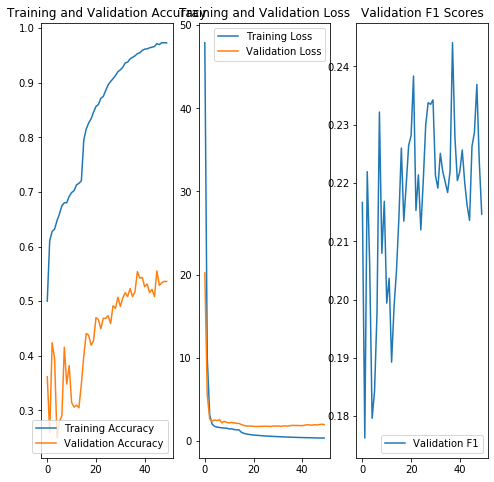

In [0]:
optimizer = Adam(learning_rate=LR)
# optimizer = SGD(learning_rate=LR)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

metrics = Metrics()

callbacks = [ LearningRateScheduler(lr_scheduler), metrics ]

history = model.fit(X_train_sm, y_train_sm, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    shuffle=True, validation_data=(X_val, y_val), callbacks=callbacks)

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, metrics.val_f1s, label='Validation F1')
plt.legend(loc='lower right')
plt.title('Validation F1 Scores')

* From the loss graph, we can comprehend that the model first trains well, and then begins to overfit since the loss starts to increase.
* Training and validation accuracy have sufficient, not too much gap.
* We keep the model with the best validation F1 scores, becuase our goal is to build a model which can give best macro average F1 score.

##### Load the best model

In [0]:
model.load_weights("model.h5")

##### Define a function which can display confusion matrix, and various other metrics like precision, recall and F1 scores.

In [0]:
def evaluate_model(y, y_pred):
    print(classification_report(y_true, y_pred, target_names=EMOTIONS))

    cm = confusion_matrix(y, y_pred)
    # cm = cm / cm.astype(np.float).sum(axis=0)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)

    ax.set_xticklabels(['']+EMOTIONS)
    ax.set_yticklabels(['']+EMOTIONS)

    plt.show()

##### Evaluation of validation set:

              precision    recall  f1-score   support

     disgust       0.04      0.04      0.04        28
       happy       0.29      0.31      0.30       181
         sad       0.16      0.16      0.16        79
        fear       0.08      0.08      0.08        25
     neutral       0.67      0.65      0.66       517

    accuracy                           0.49       830
   macro avg       0.25      0.25      0.25       830
weighted avg       0.50      0.49      0.50       830



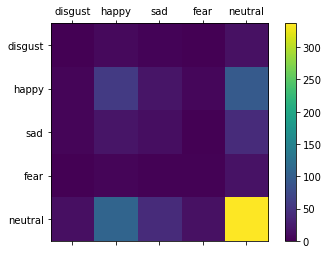

In [0]:
y_true = y_val
y_pred = np.argmax(model.predict(X_val), axis=1)
evaluate_model(y_true, y_pred)

##### Evaluation of training set:

              precision    recall  f1-score   support

     disgust       0.97      0.98      0.98      4592
       happy       0.80      0.74      0.77      4592
         sad       0.86      0.82      0.84      4592
        fear       0.98      0.99      0.99      4592
     neutral       0.68      0.75      0.71      4592

    accuracy                           0.86     22960
   macro avg       0.86      0.86      0.86     22960
weighted avg       0.86      0.86      0.86     22960



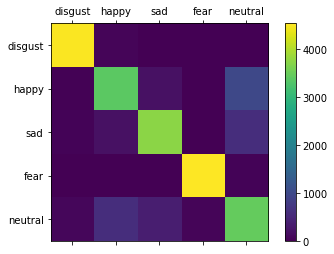

In [0]:
y_true = y_train_sm
y_pred = np.argmax(model.predict(X_train_sm), axis=1)
evaluate_model(y_true, y_pred)

##### Evaluation when the model predicts only the majority class (establish baseline):

              precision    recall  f1-score   support

     disgust       0.00      0.00      0.00        28
       happy       0.00      0.00      0.00       181
         sad       0.00      0.00      0.00        79
        fear       0.00      0.00      0.00        25
     neutral       0.62      1.00      0.77       517

    accuracy                           0.62       830
   macro avg       0.12      0.20      0.15       830
weighted avg       0.39      0.62      0.48       830



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


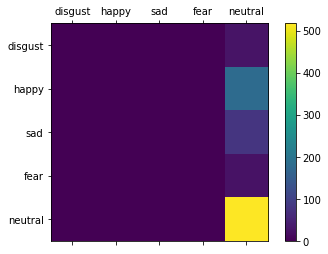

In [0]:
y_true = y_val
y_pred = np.array([4]*830)
evaluate_model(y_true, y_pred)

##### Inference:
* This model is better than the established baseline of 0.15 macro average F1 score.
* It is still heavily predicting the highest occuring class 'neutral'.
* This model is utilizing full length audios.
* 'Disgust' and 'fear' classes give the least F1 scores. It is not shocking because they were the least occuring classes in the training data set.

# Method 2: Generate spectrograms and apply CNN for classification <a id='method2'></a>

##### What I am trying to do:
* Since CNNs are very good at image classification, they have even been applied to audio classification.
* Mel spectrograms of the audio samples are fed into the the CNN for classification.
* I try mel spectrograms, MFCCS and stfts.
* I tried using both VGG and ResNet architectures.

##### Import Modules

In [0]:
import os
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm
from glob import glob
from scipy.signal import stft
import random
from matplotlib import pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score

from tensorflow.keras.layers import InputLayer, Flatten, Dense, Dropout, MaxPool2D, Conv2D
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import regularizers

##### Hyperparameters, etc

In [0]:
EPOCHS = 50
LR = 0.0001
BATCH_SIZE = 16
DROPOUT_RATE = 0.5
REG_STRENGTH = 0.01

EMOTIONS = ["disgust", "happy", "sad", "fear", "neutral"]

##### This function takes a .wav file path as input and generates a spectrogram of spec_type (which can be mel spectrogram, mfcc or stft).
I limit the length of the audio clip to be uniform. If the sample has longer length, then it gets chopped off randomly. If the length of audio sample is shorter, then we randomly add random length noise to both ends.

In [0]:
def process_wav_file(file_path, spec_type):
    y, sr = librosa.load(file_path)
    y = y.astype(np.float32) / np.iinfo(np.int16).max # Normalize
    L = 71000

    if len(y) > L:
        i = np.random.randint(0, len(y) - L)
        y = y[i:(i+L)]  

    elif len(y) < L:
        rem_len = L - len(y)
        silence_part = np.random.randint(-100,100,L).astype(np.float32) / np.iinfo(np.int16).max
        j = np.random.randint(0, rem_len)
        silence_part_left  = silence_part[0:j]
        silence_part_right = silence_part[j:rem_len]
        y = np.concatenate([silence_part_left, y, silence_part_right])

    if spec_type == 'mel':
        spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, n_mels=128, hop_length=512)
        spec_db = librosa.power_to_db(spec, ref=np.max)
        return np.expand_dims(spec_db, axis=2)

    if spec_type == 'stft':
        eps=1e-10
        threshold_freq = 5500

        freqs, times, spec = stft(y, L, nperseg = 400, noverlap = 240, nfft = 512, padded = False, boundary = None)
        
        if threshold_freq is not None:
            spec = spec[freqs <= threshold_freq,:]
            freqs = freqs[freqs <= threshold_freq]

        amp = np.log(np.abs(spec)+eps)
    
        return np.expand_dims(amp, axis=2)

    if spec_type == 'mfcc':
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128)
        return np.expand_dims(mfccs, axis=2)

##### Function to create training and validation sets.

In [0]:
def create_dataset(spec_type):
    X_train = []
    y_train = []

    DIR = "/mntDrive/My Drive/meld/train"

    wav_files = glob(DIR+"/*/*.wav")
    wav_files = [x.split(sep='/')[5] + '/' + x.split(sep='/')[6] for x in wav_files]

    for wav_file in wav_files:
        label, name = wav_file.split('/')
        label_id = EMOTIONS.index(label)  
        file_name = os.path.join(DIR, wav_file)
        X_train.append(process_wav_file(file_name, spec_type))
        y_train.append(label_id)

    X_val = []
    y_val = []

    DIR = "/mntDrive/My Drive/meld/val"

    wav_files = glob(DIR+"/*/*.wav")
    wav_files = [x.split(sep='/')[5] + '/' + x.split(sep='/')[6] for x in wav_files]

    for wav_file in wav_files:
        label, name = wav_file.split('/')
        label_id = EMOTIONS.index(label)  
        file_name = os.path.join(DIR, wav_file)
        X_val.append(process_wav_file(file_name, spec_type))
        y_val.append(label_id)

    X_train = np.array(X_train, 'float32')
    y_train = np.array(y_train)
    X_val = np.array(X_val, 'float32')
    y_val = np.array(y_val)

    mean = np.mean(X_train, axis = 0)
    std = np.std(X_train, axis = 0)

    X_train -= mean
    X_val -= mean

    X_train /= std
    X_val /= std
    
    return X_train, y_train, X_val, y_val

##### Create a keras model having a VGG16 or ResNet50 architecture.

In [0]:
def create_model(model_type, input_shape):
    """Returns tensorflow Sequential keras model"""
    model = Sequential()
    if model_type == 'vgg':
        model.add(VGG16(include_top=False, weights=None, input_shape=input_shape))
    if model_type == 'resnet':
        model.add(ResNet50(include_top=False, weights=None, input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(REG_STRENGTH)))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(REG_STRENGTH)))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(5, activation='softmax'))

    return model

##### Obtain the data splits.

In [0]:
X_train, y_train, X_val, y_val = create_dataset('mel')

# DIR = "/mntDrive/My Drive/meld/mel_data/"

# X_train = np.load(DIR+"X_train.npy")
# y_train = np.load(DIR+"y_train.npy")
# X_val = np.load(DIR+"X_val.npy")
# y_val = np.load(DIR+"y_val.npy")
# input_shape = X_train[0].shape

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, input_shape)

(7361, 128, 139, 1) (7361,) (830, 128, 139, 1) (830,) (128, 139, 1)


##### Plot an example mel spectogram from the dataset

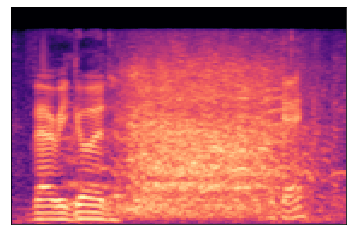

In [0]:
sf = '/mntDrive/My Drive/meld/train/happy/MEL_dia1024_utt11_positive_HAP.wav'
y, sr = librosa.load(sf)
y = y[:71000]
spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, n_mels=128, hop_length=512)
spec_db = librosa.power_to_db(spec, ref=np.max)
librosa.display.specshow(spec_db)

##### Define a custom callback so we can track the macro avg f1 scores of the model on validation set, and save the model which gives best F1 score.

In [0]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.max_f1 = 0.0
 
    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.argmax(self.model.predict(X_val), axis=1)
        y_true = y_val
        _val_f1 = f1_score(y_true, y_pred, average='macro')
        self.val_f1s.append(_val_f1)
        print (" — val_f1: %f" %(_val_f1))

        if _val_f1 > self.max_f1:
            self.model.save_weights('model.h5')
            self.max_f1 = _val_f1

        return

##### Create model instance.

In [0]:
clear_session()
model = create_model('vgg', input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14713536  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              33558528  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2

##### Build class weights.

In [0]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

##### Define custom learning rate scheduler

In [0]:
def lr_scheduler(epoch):
    if epoch<20:
        return 0.0001
    return 0.00001

##### Train model and tune hyperparameters.

Train on 7361 samples, validate on 830 samples
Epoch 1/50
7360/7361 [============================>.] - ETA: 0s - loss: 19.0665 - acc: 0.6217

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 — val_f1: 0.153526
7361/7361 [==============================] - 133s 18ms/sample - loss: 19.0640 - acc: 0.6218 - val_loss: 1.8281 - val_acc: 0.6229
Epoch 2/50
7361/7361 [==============================] - 133s 18ms/sample - loss: 1.3358 - acc: 0.6248 - val_loss: 1.1570 - val_acc: 0.6229
Epoch 3/50
7361/7361 [==============================] - 131s 18ms/sample - loss: 1.1141 - acc: 0.6248 - val_loss: 1.0957 - val_acc: 0.6229
Epoch 4/50
7361/7361 [==============================] - 132s 18ms/sample - loss: 1.0893 - acc: 0.6248 - val_loss: 1.0885 - val_acc: 0.6229
Epoch 5/50
7361/7361 [==============================] - 132s 18ms/sample - loss: 1.0828 - acc: 0.6248 - val_loss: 1.0979 - val_acc: 0.6229
Epoch 6/50
7361/7361 [==============================] - 131s 18ms/sample - loss: 1.0812 - acc: 0.6248 - val_loss: 1.0829 - val_acc: 0.6229
Epoch 7/50
7361/7361 [==============================] - 131s 18ms/sample - loss: 1.0769 - acc: 0.6248 - val_loss: 1.0801 - val_acc: 0.6229
Epoch 8/50
7361/7

Text(0.5, 1.0, 'Validation F1 Scores')

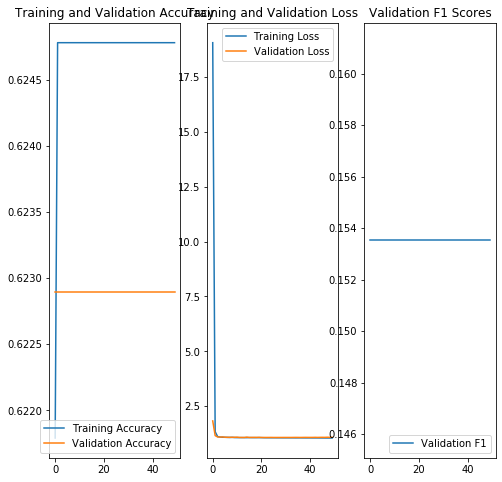

In [0]:
optimizer = Adam(learning_rate=LR)
                
metrics = Metrics()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

callbacks = [ LearningRateScheduler(lr_scheduler), metrics ]

history = model.fit(X_train, y_train, class_weight=class_weights, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    shuffle=True, validation_data=(X_val, y_val), callbacks=callbacks)
                
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, metrics.val_f1s, label='Validation F1')
plt.legend(loc='lower right')
plt.title('Validation F1 Scores')


##### Inference:
* 62.29% accuracy on validation set is nothing but the no of classes labeled as 'neutral'.
* The model has learnt to predict the majority class.
* To combat this I tried various approaches including upsampling, downsampling. The results were same.
* This model is definitely not good.

# Method 3: Apply LSTM on sequential spectogram <a id='method3'></a>

##### What I am doing:
* I divide the melspectrogram into 5 parts along it's time axis and stack these parts together. Now I apply an LSTM, but first these layers are passed through convolution and dimensionality reduction layers(pooling).
* I hoped that this will give better results because it has more data encoded it it, as well as longer temporal information is being captured.
* I got this inspiration from https://github.com/maelfabien/Multimodal-Emotion-Recognition

##### Import Modules

In [0]:
import numpy as np
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import regularizers
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE 

##### Hyperparameter, etc

In [0]:
EPOCHS = 50
LR = 0.0001
BATCH_SIZE = 16
DROPOUT_RATE = 0.5
REG_STRENGTH = 0.01

EMOTIONS = ["disgust", "happy", "sad", "fear", "neutral"]

##### Function for creating the data splits.

In [0]:
def create_dataset(spec_type):
    X_train = []
    y_train = []

    DIR = "./train"

    wav_files = glob(DIR+"/*/*.wav")
    wav_files = [x.split(sep='/')[-2] + '/' + x.split(sep='/')[-1] for x in wav_files]

    for wav_file in tqdm(wav_files):
        label, name = wav_file.split('/')
        label_id = EMOTIONS.index(label)  
        file_name = os.path.join(DIR, wav_file)
        X_train.append(process_wav_file(file_name, spec_type))
        y_train.append(label_id)

    X_val = []
    y_val = []

    DIR = "./val"

    wav_files = glob(DIR+"/*/*.wav")
    wav_files = [x.split(sep='/')[-2] + '/' + x.split(sep='/')[-1] for x in wav_files]

    for wav_file in tqdm(wav_files):
        label, name = wav_file.split('/')
        label_id = EMOTIONS.index(label)  
        file_name = os.path.join(DIR, wav_file)
        X_val.append(process_wav_file(file_name, spec_type))
        y_val.append(label_id)

    X_train = np.array(X_train, 'float32')
    y_train = np.array(y_train)
    X_val = np.array(X_val, 'float32')
    y_val = np.array(y_val)

    mean = np.mean(X_train, axis = 0)
    std = np.std(X_train, axis = 0)

    X_train -= mean
    X_val -= mean

    X_train /= std
    X_val /= std
    
    return X_train, y_train, X_val, y_val, X_train[0].shape

##### Function for finding the mel spectrogram
Also, it then divides the log scaled mel spectrogram into 5 parts along time, and stacks them together.

In [0]:
def process_wav_file(x, spec_type):
    y, sr = librosa.load(x)
    y = y.astype(np.float32) / np.iinfo(np.int16).max # Normalize
    L = 327500

    if len(y) > L:
        i = np.random.randint(0, len(y) - L)
        y = y[i:(i+L)]  

    elif len(y) < L:
        rem_len = L - len(y)
        silence_part = np.random.randint(-100,100,L).astype(np.float32) / np.iinfo(np.int16).max
        j = np.random.randint(0, rem_len)
        silence_part_left  = silence_part[0:j]
        silence_part_right = silence_part[j:rem_len]
        y = np.concatenate([silence_part_left, y, silence_part_right])

    if spec_type == 'mel':
        spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, n_mels=128, hop_length=512)
        spec_db = librosa.power_to_db(spec, ref=np.max)
        splitted = np.array(np.hsplit(spec_db, 5))
        return np.expand_dims(splitted, axis=3)

##### Form the data splits

In [9]:
# X_train, y_train, X_val, y_val, input_shape = create_dataset('mel')

DIR = "/mntDrive/My Drive/meld/multimodelEmotionRecog/"

X_train = np.load(DIR+"X_train.npy")
y_train = np.load(DIR+"y_train.npy")
X_val = np.load(DIR+"X_val.npy")
y_val = np.load(DIR+"y_val.npy")
input_shape = X_train[0].shape

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, input_shape)

(7354, 5, 128, 128, 1) (7354,) (830, 5, 128, 128, 1) (830,) (5, 128, 128, 1)


##### Create the tensorflow keras LSTM model
* Time distributed layers allow us to apply layers on temporal slices of data, preserving the temporal info.
* This model inspiration I have taken from https://github.com/maelfabien/Multimodal-Emotion-Recognition.
* Convolution and pooling is being performed, along with batch normalization. Batch normalization forces the activations throughout the network to take unit gaussian distribution. This ensures that proper weight initialization is not a problem anymore.

In [0]:
clear_session()

input_y = Input(shape=X_train.shape[1:])

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'))(input_y)
y = TimeDistributed(BatchNormalization())(y)
y = TimeDistributed(Activation('elu'))(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))(y)
y = TimeDistributed(Dropout(0.2))(y)     

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'))(y)
y = TimeDistributed(BatchNormalization())(y)
y = TimeDistributed(Activation('elu'))(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))(y)
y = TimeDistributed(Dropout(0.2))(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))(y)
y = TimeDistributed(BatchNormalization())(y)
y = TimeDistributed(Activation('elu'))(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))(y)
y = TimeDistributed(Dropout(0.2))(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))(y)
y = TimeDistributed(BatchNormalization())(y)
y = TimeDistributed(Activation('elu'))(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))(y)
y = TimeDistributed(Dropout(0.2))(y)  

y = TimeDistributed(Flatten())(y)                      
                               
y = LSTM(256, return_sequences=False, dropout=0.2)(y)

y = Dense(512, activation='relu')(y)
y = Dropout(0.2)(y)
y = Dense(512, activation='relu')(y)
y = Dropout(0.2)(y)

y = Dense(5, activation='softmax')(y)

model = Model(inputs=input_y, outputs=y)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 128, 128, 1)]  0         
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 128, 128, 64)   640       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 128, 128, 64)   256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 128, 128, 64)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5, 64, 64, 64)     0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 64, 64, 64)     0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 5, 64, 64, 64)     36928 

##### Evaluate the class weights to counter class imbalance.

In [0]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

##### Define a custom callback so we can track the macro avg f1 scores of the model on validation set, and save the model which gives best F1 score.

In [0]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.max_f1 = 0.0
 
    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.argmax(self.model.predict(X_val), axis=1)
        y_true = y_val
        _val_f1 = f1_score(y_true, y_pred, average='macro')
        self.val_f1s.append(_val_f1)
        print (" — val_f1: %f" %(_val_f1))

        if _val_f1 > self.max_f1:
            self.model.save_weights('model.h5')
            self.max_f1 = _val_f1

        return

##### Define custom learning rate scheduler

In [0]:
def lr_scheduler(epoch):
    if epoch<20:
        return 0.0001
    return 0.00001

##### Run the model

In [0]:
optimizer = Adam(learning_rate=LR)
                
metrics = Metrics()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

callbacks = [ LearningRateScheduler(lr_scheduler), metrics ]

history = model.fit(X_train, y_train, class_weight=class_weights, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    shuffle=True, validation_data=(X_val, y_val), callbacks=callbacks)
                
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, metrics.val_f1s, label='Validation F1')
plt.legend(loc='lower right')
plt.title('Validation F1 Scores')


Train on 7354 samples, validate on 830 samples
Epoch 1/50
7344/7354 [============================>.] - ETA: 0s - loss: 1.0834 - acc: 0.6212

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 — val_f1: 0.153526
7354/7354 [==============================] - 120s 16ms/sample - loss: 1.0835 - acc: 0.6213 - val_loss: 1.1103 - val_acc: 0.6229
Epoch 2/50
7354/7354 [==============================] - 117s 16ms/sample - loss: 1.0743 - acc: 0.6244 - val_loss: 1.0799 - val_acc: 0.6229
Epoch 3/50
7354/7354 [==============================] - 117s 16ms/sample - loss: 1.0705 - acc: 0.6244 - val_loss: 1.0768 - val_acc: 0.6229
Epoch 4/50
7354/7354 [==============================] - 117s 16ms/sample - loss: 1.0676 - acc: 0.6244 - val_loss: 1.0716 - val_acc: 0.6229
Epoch 5/50
7354/7354 [==============================] - 117s 16ms/sample - loss: 1.0700 - acc: 0.6244 - val_loss: 1.0735 - val_acc: 0.6229
Epoch 6/50
7354/7354 [==============================] - 117s 16ms/sample - loss: 1.0698 - acc: 0.6244 - val_loss: 1.0776 - val_acc: 0.6229
Epoch 7/50
7354/7354 [==============================] - 116s 16ms/sample - loss: 1.0665 - acc: 0.6244 - val_loss: 1.0787 - val_acc: 0.6229
Epoch 8/50
7354/73

##### Inference:
* This model suffered from the same problem as the model in method 2.
* Either it predicts only one class like above.
* Or if I perform any down/upsampling, the resultant macro f1 score becomes lower than the baseline of 15.
* Hence, this model also doesn't beat the first model.
* It means that either the data obtained from mel spectrograms contains very low correlated data, or that the network doesn't have enough capacity/complexity.

# Method 4: Infuse LSTM extracted feature vector with the opensmile features <a id='method4'></a>

##### What I am trying to do?
* I want to see if we can combine opensmile features and the LSTM output layer to fuse their scores and maybe there is some interdependent information that can be found.
* So I feed these fused (concatenated) values into two FC Layers and train the network in this manner.

##### Load the opensmile features data

In [1]:
DIR = "/mntDrive/My Drive/meld/"
X_train_os = np.load(DIR+"X_train.npy")
X_val_os = np.load(DIR+"X_val.npy")

NameError: name 'np' is not defined

##### Zero centre and normalization

In [14]:
mean = np.mean(X_train_os, axis = 0)
std = np.std(X_train_os, axis = 0)

X_train_os -= mean
X_val_os -= mean

X_train_os = np.divide(X_train_os, std, out=np.zeros_like(X_train_os), where=std!=0)
X_val_os = np.divide(X_val_os, std, out=np.zeros_like(X_val_os), where=std!=0)

print(X_train_os.shape)

(7354, 6553)


In [0]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.max_f1 = 0.0
 
    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.argmax(self.model.predict((X_val, X_val_os)), axis=1)
        y_true = y_val
        _val_f1 = f1_score(y_true, y_pred, average='macro')
        self.val_f1s.append(_val_f1)
        print (" — val_f1: %f" %(_val_f1))

        if _val_f1 > self.max_f1:
            self.model.save_weights('model.h5')
            self.max_f1 = _val_f1

        return

##### In the LSTM model that we had created, I infused the opensmile features just before the final FC layers. The reason for doing this fusion before the FC layers is so that interdependence relations can be learnt by the FC layers.

In [21]:
clear_session()

input_y = Input(shape=X_train.shape[1:])

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'))(input_y)
y = TimeDistributed(BatchNormalization())(y)
y = TimeDistributed(Activation('elu'))(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))(y)
y = TimeDistributed(Dropout(0.2))(y)     

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'))(y)
y = TimeDistributed(BatchNormalization())(y)
y = TimeDistributed(Activation('elu'))(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))(y)
y = TimeDistributed(Dropout(0.2))(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))(y)
y = TimeDistributed(BatchNormalization())(y)
y = TimeDistributed(Activation('elu'))(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))(y)
y = TimeDistributed(Dropout(0.2))(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))(y)
y = TimeDistributed(BatchNormalization())(y)
y = TimeDistributed(Activation('elu'))(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))(y)
y = TimeDistributed(Dropout(0.2))(y)  

y = TimeDistributed(Flatten())(y)                      
                               
y = LSTM(256, return_sequences=False, dropout=0.2)(y)

input_os = Input(shape=(6553))

y = Concatenate()([y, input_os])
y = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(REG_STRENGTH))(y)
y = Dropout(0.2)(y)
y = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(REG_STRENGTH))(y)
y = Dropout(0.2)(y)

y = Dense(5, activation='softmax')(y)

# Build final model
model = Model(inputs=(input_y, input_os), outputs=y)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 128, 128, 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 5, 128, 128,  640         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 5, 128, 128,  256         time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 5, 128, 128,  0           time_distributed_1[0][0]         
______________________________________________________________________________________________

##### Run the model

Train on 7354 samples, validate on 830 samples
Epoch 1/50
7344/7354 [============================>.] - ETA: 0s - loss: 13.7588 - acc: 0.5746

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 — val_f1: 0.226041
7354/7354 [==============================] - 39s 5ms/sample - loss: 13.7557 - acc: 0.5747 - val_loss: 11.8289 - val_acc: 0.6084
Epoch 2/50
7354/7354 [==============================] - 37s 5ms/sample - loss: 10.3044 - acc: 0.6171 - val_loss: 9.0164 - val_acc: 0.6145
Epoch 3/50
7354/7354 [==============================] - 37s 5ms/sample - loss: 7.7516 - acc: 0.6295 - val_loss: 6.8793 - val_acc: 0.5940
Epoch 4/50
7354/7354 [==============================] - 37s 5ms/sample - loss: 5.8490 - acc: 0.6410 - val_loss: 5.2318 - val_acc: 0.6012
Epoch 5/50
7354/7354 [==============================] - 37s 5ms/sample - loss: 4.4683 - acc: 0.6475 - val_loss: 4.1506 - val_acc: 0.5988
Epoch 6/50
7354/7354 [==============================] - 37s 5ms/sample - loss: 3.4993 - acc: 0.6511 - val_loss: 3.3560 - val_acc: 0.6084
Epoch 7/50
7354/7354 [==============================] - 37s 5ms/sample - loss: 2.8207 - acc: 0.6573 - val_loss: 2.7998 - val_acc: 0.6193
Epoch 8/50
7354/7354 [=======

Text(0.5, 1.0, 'Validation F1 Scores')

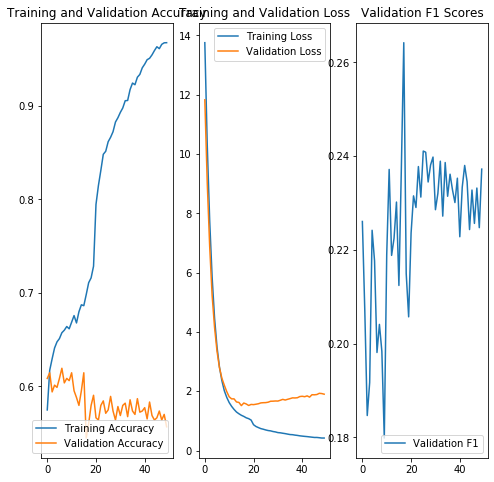

In [22]:
optimizer = Adam(learning_rate=LR)
                
metrics = Metrics()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

callbacks = [ LearningRateScheduler(lr_scheduler), metrics ]

history = model.fit((X_train, X_train_os), y_train, class_weight=class_weights, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    shuffle=True, validation_data=((X_val, X_val_os), y_val), callbacks=callbacks)
                
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, metrics.val_f1s, label='Validation F1')
plt.legend(loc='lower right')
plt.title('Validation F1 Scores')

##### Inference:
* The loss shows that the model starts overfitting at about epoch 20 when the validation loss starts increasing while the training loss continues to decrease.
* The peak in validation F1 macro average also appears to come at the same time. This model is saved as best model

##### Load the best model based on validation F1 macro avg score.

In [0]:
model.load_weights("model.h5")

##### Define a function which can display confusion matrix, and various other metrics like precision, recall and F1 scores.

In [0]:
def evaluate_model(y, y_pred):
    print(classification_report(y_true, y_pred, target_names=EMOTIONS))

    cm = confusion_matrix(y, y_pred)
    # cm = cm / cm.astype(np.float).sum(axis=0)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)

    ax.set_xticklabels(['']+EMOTIONS)
    ax.set_yticklabels(['']+EMOTIONS)

    plt.show()

##### Evaluate the model

              precision    recall  f1-score   support

     disgust       0.20      0.11      0.14        28
       happy       0.32      0.23      0.26       181
         sad       0.23      0.18      0.20        79
        fear       0.00      0.00      0.00        25
     neutral       0.66      0.79      0.72       517

    accuracy                           0.56       830
   macro avg       0.28      0.26      0.26       830
weighted avg       0.51      0.56      0.53       830



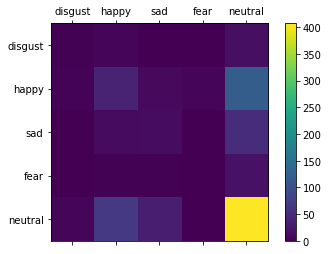

In [27]:
y_true = y_val
y_pred = np.argmax(model.predict((X_val, X_val_os)), axis=1)
evaluate_model(y_true, y_pred)

##### Inference:
* The model gives very slightly better results than the vanilla model trained on only opensmile features. It is better at classifying disgust, sad and neutral emotions, but it performs horribly on fear.
* Slightly better macro avg F1, accuracy and weighted averages are obtained.
* The reason for this could either be that a little more extra info is being found from the LSTM. 
* However it could also just be a matter of better random initialization.

# Result <a id='result'></a>

* Methods 1 and 4 gave the best results, and had tradeoffs in the sense of model complexities, and their ability to classify different emotions
* The fact that the dataset is heavily imbalanced and we have very few data points for some classes proves to be a major hurdle.

# Future Discussions

* I further would have liked to experiment with PocketSphinx, a library for locally converting audio to text. This would probably give huge imporvements. 
* Also, Openl3 is a library that also generates features, and claims to be state of the art. I would like to try building a model which uses features extracted by both opensmile and Openl3.
* Another thing that I would liked to have tried is increasing the no of samples of under represented class by using audio data augmentation.
* Also, using opensmile we can get VADs which can also be passed to an RNN or LSTM. That would also be something worth exploring.
* I would also like to use ensembles of the best models, and use tricks used by ensemble learning to maybe get a little bump in results.

# Miscellaneous

### 1. Generating batches of audio data to speed up execution and reduce memory consumption.
However because the google drive disks are way too slow, it made more sense to keep the entire data in memory. Hence I am just mentioning the code for generating batches of audio data because there is no explicit class like ImageDataGenerator for audio data.

In [0]:
def process_wav_file(x):
  y, sr = librosa.load(x)
  y = y.astype(np.float32) / np.iinfo(np.int16).max # Normalize
  L = 16000

  if len(y) > L:
    i = np.random.randint(0, len(y) - L)
    y = y[i:(i+L)]  

  elif len(y) < L:
    rem_len = L - len(y)
    silence_part = np.random.randint(-100,100,16000).astype(np.float32) / np.iinfo(np.int16).max
    j = np.random.randint(0, rem_len)
    silence_part_left  = silence_part[0:j]
    silence_part_right = silence_part[j:rem_len]
    y = np.concatenate([silence_part_left, y, silence_part_right])

  spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, n_mels=128)
  spec_db = librosa.power_to_db(spec, ref=np.max)
  return spec_db.reshape((spec_db.shape[0], spec_db.shape[1], 1))

In [0]:
class AudioSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x_audio = []

        for x in batch_x:
          batch_x_audio.append(process_wav_file(x))

        return np.array(batch_x_audio), np.array(batch_y)

In [0]:
BATCH_size = 32
generator = AudioSequence(X_train, y_train, BATCH_SIZE)

### 2. Applying XGBoost on the features generated by opensmile

I did not spend much time on this, it wasn't giving any promising results; still I have mentioned it that I tried using it.

In [0]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [0]:
DIR = "/mntDrive/My Drive/meld/"
X_train = np.load(DIR+"X_train.npy")
y_train = np.load(DIR+"y_train.npy")
X_val = np.load(DIR+"X_val.npy")
y_val = np.load(DIR+"y_val.npy")

In [0]:
# model = XGBClassifier(silent=False, objective='multi:softmax', max_depth=1)
# model.fit(X_train, y_train)

# model = XGBClassifier(n_estimators=1, objective='multi:softmax')

# eval_set = [(X_train, y_train), (X_val, y_val)]
# eval_metric = ["mlogloss"]

# model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

In [0]:
# dtrain = xgb.DMatrix(data=X_train, label=y_train)
# dval = xgb.DMatrix(data=X_val)
# params = {
#     'max_depth': 10,
#     'objective': 'multi:softmax',
#     'num_class': 5,
#     'n_gpus': 1
# }
# bst = xgb.train(params, dtrain)
# pred = bst.predict(dval)
# print(classification_report(y_val, pred))

In [0]:
xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=42, tree_method='gpu_hist')

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, return_train_score=True)

search.fit(X_train, y_train)

report_best_scores(search.cv_results_, 1)